In [3]:
import numpy as np

def siv_AMDF_04(x, Fs):
    # Step 1: Get the length of the signal
    N = len(x)  # Same as MATLAB's N=length(x);

    # Step 2: Initialize the output array D with zeros, of size (N-1)
    D = np.zeros(N - 1)  # MATLAB's D(k)=0 for each k

    # Step 3: Outer loop over lag values k = 1 to N-1
    for k in range(1, N):  # MATLAB: for k=1:N-1
        # Inner loop: compute sum of |x(n) - x(n+k)| for n = 0 to N-k-1
        for n in range(N - k):  # MATLAB: for n=1:N-k (0-indexed in Python)
            # Accumulate the absolute differences
            D[k - 1] += abs(x[n] - x[n + k])  # MATLAB: abs(x(n)-x(n+k))

        # Step 4: Average the sum over the number of terms
        D[k - 1] = D[k - 1] / (N - k)  # MATLAB: D(k)=D(k)/(N-k);

    return D


import numpy as np
from scipy.signal import filtfilt

def siv_moving_avg_fil(x, N):
    # Line 1: x = input signal, N = window size
    # (Already handled in function arguments)

    # Line 2: Create moving average filter kernel of length N
    b = np.ones(N) / N  # Equivalent to MATLAB's b = ones(N, 1)/N

    # Line 3: Apply zero-phase filtering using filtfilt
    y = filtfilt(b, 1, x)  # Forward and backward filtering

    # Line 4: Return filtered signal
    return y


import numpy as np

def siv_neg_zero_cross(ydif):
    zerocross = []
    i = 1  # start from index 1 to mimic MATLAB's 1-based indexing

    while i < len(ydif) - 1:
        # Check for negative-going threshold crossing at -0.25
        if ydif[i] > -0.25 and ydif[i + 1] <= -0.25:
            # Choose between i-1 and i based on magnitude
            if abs(ydif[i]) > abs(ydif[i - 1]):
                zerocross.append(i - 1)
            else:
                zerocross.append(i)
        i += 1

    # If no crossings found, assign default
    if len(zerocross) == 0:
        zerocross = [1, 1]

    # If first crossing is too early, discard it
    if zerocross[0] <= 5:
        zerocross = zerocross[1:]

    # Recheck again in case list became empty after above operation
    if len(zerocross) == 0:
        zerocross = [1, 1]

    # Ensure at least 2 elements
    if len(zerocross) == 1:
        zerocross.append(1)

    return zerocross



import numpy as np

def siv_peakanno_AMDF(ym):
    # Step 1: Compute the gradient (derivative)
    ydif = np.gradient(ym)

    # Optional smoothing (commented out in MATLAB)
    # ydif = siv_moving_avg_fil(ydif, 3)

    # Step 2: Zero out the first three samples
    ydif[:3] = 0

    # Step 3: Normalize to maximum absolute value
    max_val = np.max(np.abs(ydif))
    if max_val != 0:
        ydif = ydif / max_val

    # Step 4: Find negative zero-crossings
    zerocross = siv_neg_zero_cross(ydif)

    # Step 5: Handle case where zerocross[0] == 1
    if zerocross[0] == 1:
        zerocross[0] = np.max(ym)  # Replace with peak value

    return ydif, zerocross


import numpy as np

def siv_th_cross(x, m='b', th=0.1):
    s = x >= th  # Step 1: Thresholding
    k = s[1:].astype(int) - s[:-1].astype(int)  # Step 2: Transitions (diff)

    if 'p' in m:  # Positive edge crossing
        f = np.where(k > 0)[0]
    elif 'n' in m:  # Negative edge crossing
        f = np.where(k < 0)[0]
    else:  # Any crossing
        f = np.where(k != 0)[0]

    return f + 1  # MATLAB uses f+1 due to indexing

def msm_zerocros(x, mode='p'):
    x = np.asarray(x)
    s = x >= 0
    k = np.diff(s.astype(int))
    if 'p' in mode:
        f = np.where(k > 0)[0]
    elif 'n' in mode:
        f = np.where(k < 0)[0]
    else:
        f = np.where(k != 0)[0]
    zcr = f
    slope = x[f + 1] - x[f] if len(f) > 0 else np.array([0])
    if len(zcr) == 0:
        zcr = np.array([0])
    return zcr, slope



In [13]:
import numpy as np
import pandas as pd

from scipy.signal import cheby1, filtfilt

x123 = pd.read_csv('NF2_New_crt_clean_PPG_LSBP_0_segments.csv', header=None).values

xcn = x123

SQ = []     # equivalent to: SQ = zeros in MATLAB
PR = []     # to store [rec, i, PR_o] for each block
Esto = []   # to store quality-related parameters
BN1 = 1  # BN1=1;
good_segments=[];

for rec in range(xcn.shape[0]):  # for rec=1:size(xcn,1)
    val = xcn[rec, :]  # val=xcn(rec,:);

    Fs = 125  # Fs=125;
    Bck_size = 5  # Bck_size=5;
    L1 = len(val)  # L1=length(val);
    BL = int(Bck_size * Fs)  # BL=floor(Bck_size*Fs);
    N1 = 0  # N1=1;
    NE = N1 + BL  # NE=N1+BL-1;
    i = 1  # i=1;

    AMDF_h = int(2 * (60 * Fs) / 30)  # AMDF_h=2*(60*Fs)/30;
    th = 0.1  # th=0.1;
    thm = -0.1  # thm=-0.1;

    while NE <= L1:  # while (NE<=L1)
        x1 = val[N1:NE]  # xo=val(N1:NE);
        N1 = NE  # N1=NE+1;
        NE = N1 + BL  # NE=N1+BL-1;

        famp = np.max(np.abs(x1))  # [famp,~]=max(abs(xo));
        xo = x1 / famp  # xo=xo/famp;

        b0, a0 = cheby1(5, 0.001, 1 / Fs, btype='high')  # [b0,a0]=cheby1(5,0.001,1/Fs,"high");
        xo = filtfilt(b0, a0, xo)  # xo = filtfilt(b0, a0, xo);
        xo = xo / np.max(np.abs(xo))  # xo=xo/max(abs(xo));

        xd = np.diff(xo)  # xd=diff(xo);
        b1 = np.ones(3) / 3  # b1=rectwin(3)./3;
        a1 = 1  # a1=1;
        xs = filtfilt(b1, a1, xd)  # xs=filtfilt(b1,a1,xd);

        PZC, S1 = msm_zerocros(xs, 'all')  # [PZC,S1]=msm_zerocros(xs,'all');
        NPZCR = len(PZC)  # NPZCR=numel(PZC);

        AMDFo = siv_AMDF_04(xo, Fs)  # AMDFo=siv_AMDF_04(xo,Fs);
        AMDFo = AMDFo[:AMDF_h]  # AMDFo=AMDFo(1:AMDF_h);
        AMDFo = AMDFo - np.mean(AMDFo)  # AMDFo=AMDFo-mean(AMDFo);
        famp = np.max(np.abs(AMDFo))  # [famp,~]=max(abs(AMDFo));
        AMDFo = AMDFo / famp  # AMDFo=AMDFo/famp;

        sam_o = np.arange(1, len(AMDFo) + 1)  # sam_o=1:length(AMDFo);

        _, locs2 = siv_peakanno_AMDF(-AMDFo)  # [~,locs2] = siv_peakanno_AMDF(-AMDFo);

        if locs2[0] > 15 and locs2[0] <= AMDF_h - 15:  # if locs2(1)>15 && locs2(1)<=AMDF_h-15
            window = AMDFo[locs2[0] - 10: locs2[0] + 11]  # [~,ref]=min(AMDFo(locs2(1)-10:locs2(1)+10));
            ref = np.argmin(window)
            locs2[0] = ref + locs2[0] - 10  # locs2(1)=ref+locs2(1)-11;

        PR_o = int(np.floor(60 * Fs / locs2[0]))  # PR_o=floor(60*Fs/locs2(1));

        cross_th_o = siv_th_cross(xo, 'b', th)  # cross_th_o=siv_th_cross(xo,'b',th);
        cross_thm_o = siv_th_cross(xo, 'b', thm)  # cross_thm_o=siv_th_cross(xo,'b',thm);

        N = len(locs2)  # N=length(locs2);
        if locs2[0] == 1 or locs2[1] == 1:  # if (locs2(1)==1 || locs2(2)==1)
            N = 0  # N=0;

        mag = abs(len(cross_th_o) - len(cross_thm_o))  # mag=abs(length(cross_th_o)-length(cross_thm_o));
                # Esto(BN1,1:7+length(locs2))=[rec,i,length(cross_th_o),length(cross_thm_o),N,AMDFo(locs2(1)),AMDFo(locs2(2)),locs2];
        est = [rec + 1, i, len(cross_th_o), len(cross_thm_o), N, AMDFo[locs2[0]], AMDFo[locs2[1]], *locs2]

        # MATLAB uses preallocated matrix, in Python we usually append
        Esto.append(est)

        # mag=abs(length(cross_th_o)-length(cross_thm_o));
        mag = abs(len(cross_th_o) - len(cross_thm_o))

        # if (NPZCR>8 && NPZCR<=38)
        if NPZCR > 8 and NPZCR <= 38:
            SQ.append(0)  # SQ(BN1,1)=0;

        # elseif (NPZCR>38 && NPZCR<168)
        elif NPZCR > 38 and NPZCR < 168:
            SQ.append(1)  # SQ(BN1,1)=1;

        # elseif (N<2 || PR_o<30 || PR_o>300)
        elif N < 2 or PR_o < 30 or PR_o > 300:
            SQ.append(1)  # SQ(BN1,1)=1;

        # elseif ((AMDFo(locs2(1))>0.13 && AMDFo(locs2(2))>-0.35) && mag>64)
        elif (AMDFo[locs2[0]] > 0.13 and AMDFo[locs2[1]] > -0.35 and mag > 64):
            SQ.append(1)  # SQ(BN1,1)=1;

        # elseif ((AMDFo(locs2(1))<0.37 && AMDFo(locs2(2))<-0.34) && mag<=9)
        elif (AMDFo[locs2[0]] < 0.37 and AMDFo[locs2[1]] < -0.34 and mag <= 9):
            SQ.append(0)  # SQ(BN1,1)=0;

        # else
        else:
            # range=[0,locs2];
            range_vals = [0] + locs2

            # distance=diff(range);
            distance = np.diff(range_vals)

            # dist=diff(distance);
            dist = np.diff(distance)

            # for k=1:length(dist)
            flag = 0
            for k in range(len(dist)):
                # if (dist(k)>8)
                if dist[k] > 8:
                    SQ.append(1)  # SQ(BN1,1)=1;
                    flag = 1
                    break
            if flag == 0:
                SQ.append(0)
                

        # PR(BN1,:)=[rec,i,PR_o];
        PR.append([rec + 1, i, PR_o])

        # i=i+1;
        i += 1

        # BN1=BN1+1;
        BN1 += 1


SQ = np.atleast_1d(np.array(SQ))
good_quality = xcn[SQ == 0, :]  # Good segments (SQ == 0)


# disp(length(find(SQ==0)))        % Good Quality
print(len([s for s in SQ if s == 0]))  # Good Quality

# disp(length(find(SQ==1)))        % Bad Quality
print(len([s for s in SQ if s == 1]))  # Bad Quality

872
128


In [145]:
import numpy as np

def msm_zerocros(x, mode='p'):
    x = np.asarray(x)
    s = x >= 0
    k = np.diff(s.astype(int))
    if 'p' in mode:
        f = np.where(k > 0)[0]
    elif 'n' in mode:
        f = np.where(k < 0)[0]
    else:
        f = np.where(k != 0)[0]
    zcr = f
    slope = x[f + 1] - x[f] if len(f) > 0 else np.array([0])
    if len(zcr) == 0:
        zcr = np.array([0])
    return zcr, slope

def peak_onset_tcr_CS(xbo, th2):
    spT, spAT, onsetT, onsetAT = [], [], [], []

    xb1 = [1 if val > th2 else -1 for val in xbo]
    xb1 = np.array(xb1) - np.mean(xb1)

    nzcrf, _ = msm_zerocros(xb1, 'n')
    pzcrf, _ = msm_zerocros(xb1, 'p')

    totalzcrf = len(nzcrf) + len(pzcrf)
    lzcrf = min(len(nzcrf), len(pzcrf))

    if len(pzcrf) > len(nzcrf):
        if nzcrf[0] > pzcrf[0]:
            for i in range(lzcrf):
                spa = np.max(xbo[pzcrf[i]:nzcrf[i]+1])
                spl1 = np.argmax(xbo[pzcrf[i]:nzcrf[i]+1])
                sp = pzcrf[i] + spl1
                spT.append(sp)
                spAT.append(spa)

                onseta = np.min(xbo[nzcrf[i]:pzcrf[i+1]+1])
                onsetl1 = np.argmin(xbo[nzcrf[i]:pzcrf[i+1]+1])
                onset = nzcrf[i] + onsetl1
                onsetT.append(onset)
                onsetAT.append(onseta)
        else:
            for i in range(lzcrf):
                spa = np.max(xbo[pzcrf[i]:nzcrf[i+1]+1])
                spl1 = np.argmax(xbo[pzcrf[i]:nzcrf[i+1]+1])
                sp = pzcrf[i] + spl1
                spT.append(sp)
                spAT.append(spa)

                onseta = np.min(xbo[nzcrf[i]:pzcrf[i]+1])
                onsetl1 = np.argmin(xbo[nzcrf[i]:pzcrf[i]+1])
                onset = nzcrf[i] + onsetl1
                onsetT.append(onset)
                onsetAT.append(onseta)
    else:
        if len(nzcrf) == len(pzcrf):
            if nzcrf[0] > pzcrf[0]:
                for i in range(lzcrf):
                    spa = np.max(xbo[pzcrf[i]:nzcrf[i]+1])
                    spl1 = np.argmax(xbo[pzcrf[i]:nzcrf[i]+1])
                    sp = pzcrf[i] + spl1
                    spT.append(sp)
                    spAT.append(spa)

                    if i <= lzcrf - 2:
                        onseta = np.min(xbo[nzcrf[i]:pzcrf[i+1]+1])
                        onsetl1 = np.argmin(xbo[nzcrf[i]:pzcrf[i+1]+1])
                        onset = nzcrf[i] + onsetl1
                        onsetT.append(onset)
                        onsetAT.append(onseta)
            else:
                for i in range(lzcrf):
                    if i <= lzcrf - 2:
                        spa = np.max(xbo[pzcrf[i]:nzcrf[i+1]+1])
                        spl1 = np.argmax(xbo[pzcrf[i]:nzcrf[i+1]+1])
                        sp = pzcrf[i] + spl1
                        spT.append(sp)
                        spAT.append(spa)

                    onseta = np.min(xbo[nzcrf[i]:pzcrf[i]+1])
                    onsetl1 = np.argmin(xbo[nzcrf[i]:pzcrf[i]+1])
                    onset = nzcrf[i] + onsetl1
                    onsetT.append(onset)
                    onsetAT.append(onseta)
        else:
            if nzcrf[0] > pzcrf[0]:
                for i in range(lzcrf):
                    spa = np.max(xbo[pzcrf[i]:nzcrf[i]+1])
                    spl1 = np.argmax(xbo[pzcrf[i]:nzcrf[i]+1])
                    sp = pzcrf[i] + spl1
                    spT.append(sp)
                    spAT.append(spa)

                    if i <= lzcrf - 2:
                        onseta = np.min(xbo[nzcrf[i]:pzcrf[i+1]+1])
                        onsetl1 = np.argmin(xbo[nzcrf[i]:pzcrf[i+1]+1])
                        onset = nzcrf[i] + onsetl1
                        onsetT.append(onset)
                        onsetAT.append(onseta)
            else:
                for i in range(lzcrf):
                    spa = np.max(xbo[pzcrf[i]:nzcrf[i+1]+1])
                    spl1 = np.argmax(xbo[pzcrf[i]:nzcrf[i+1]+1])
                    sp = pzcrf[i] + spl1
                    spT.append(sp)
                    spAT.append(spa)

                    onseta = np.min(xbo[nzcrf[i]:pzcrf[i]+1])
                    onsetl1 = np.argmin(xbo[nzcrf[i]:pzcrf[i]+1])
                    onset = nzcrf[i] + onsetl1
                    onsetT.append(onset)
                    onsetAT.append(onseta)

    return spT, spAT, onsetT, onsetAT




import numpy as np
import pandas as pd

def sp_onset_post_processing_new3rules_modified(xbo, THB, RTHB):
    spT, spAT, onsetT, onsetAT = peak_onset_tcr_CS(xbo, THB)
    spT = np.array(spT)
    onsetT = np.array(onsetT)
    spAT = np.array(spAT)
    onsetAT = np.array(onsetAT)

    if spT[0] < onsetT[0]:
        # Rule 01
        PonsetT = []
        PonsetTL = []
        check = 0
        for i in range(len(onsetT)):
            if onsetAT[i] > 0:
                PonsetT.append(onsetT[i])
                PonsetTL.append(i)

        if len(PonsetT) >= 1:
            PonsetT = np.array(PonsetT)
            PonsetTL = np.array(PonsetTL)
            if len(PonsetT) == 1:
                if PonsetT[-1] == onsetT[-1]:
                    check = 1
                else:
                    CPspT = spT[PonsetTL + 1]
            else:
                if PonsetT[-1] == onsetT[-1] and PonsetT[-1] > spT[-1]:
                    CPspT = [spT[PonsetTL[i] + 1] for i in range(len(PonsetT) - 1)]
                else:
                    CPspT = spT[PonsetTL + 1]

            if check == 0:
                spT = np.setdiff1d(spT, CPspT)
                onsetT = np.setdiff1d(onsetT, PonsetT)
                spAT = xbo[spT]
                onsetAT = xbo[onsetT]

        # Rule 02
        NspT = []
        NspTL = []
        for i in range(1, len(spT)):
            if spAT[i] < 0:
                NspT.append(spT[i])
                NspTL.append(i)

        if len(NspT) >= 1:
            CNonsetT = onsetT[np.array(NspTL) - 1]
            spT = np.setdiff1d(spT, NspT)
            onsetT = np.setdiff1d(onsetT, CNonsetT)
            spAT = xbo[spT]
            onsetAT = xbo[onsetT]

        # Rule 03
        exsp = 0
        RspT = []
        for i in range(2, len(spT)):
            if spAT[i] < RTHB * spAT[i - 1]:
                RspT.append(i)
                spT[i] = spT[i - 1]
                spAT[i] = xbo[spT[i]]
                exsp += 1

        spT = np.unique(spT)
        spAT = xbo[spT]

        if exsp >= 1:
            RonsetTL = np.array(RspT) - 1
            RonsetT = onsetT[RonsetTL]
            onsetT = np.setdiff1d(onsetT, RonsetT)
            onsetAT = xbo[onsetT]

    else:
        # Rule 01
        PonsetT = []
        PonsetTL = []
        check = 0
        for i in range(len(onsetT)):
            if onsetAT[i] > 0:
                PonsetT.append(onsetT[i])
                PonsetTL.append(i)

        if len(PonsetT) >= 1:
            PonsetT = np.array(PonsetT)
            PonsetTL = np.array(PonsetTL)
            if len(PonsetT) == 1:
                if PonsetT[-1] == onsetT[-1]:
                    check = 1
                else:
                    CPspT = spT[PonsetTL]
            else:
                if PonsetT[-1] == onsetT[-1] and PonsetT[-1] > spT[-1]:
                    CPspT = [spT[PonsetTL[i]] for i in range(len(PonsetT) - 1)]
                else:
                    CPspT = spT[PonsetTL]

            if check == 0:
                spT = np.setdiff1d(spT, CPspT)
                onsetT = np.setdiff1d(onsetT, PonsetT)
                spAT = xbo[spT]
                onsetAT = xbo[onsetT]

        # Rule 02
        NspT = []
        NspTL = []
        for i in range(len(spT)):
            if spAT[i] < 0:
                NspT.append(spT[i])
                NspTL.append(i)

        if len(NspT) >= 1:
            CNonsetT = onsetT[NspTL]
            spT = np.setdiff1d(spT, NspT)
            onsetT = np.setdiff1d(onsetT, CNonsetT)
            spAT = xbo[spT]
            onsetAT = xbo[onsetT]

        # Rule 03
        exsp = 0
        RspT = []
        for i in range(1, len(spT)):
            if spAT[i] < RTHB * spAT[i - 1]:
                RspT.append(i)
                spT[i] = spT[i - 1]
                spAT[i] = xbo[spT[i]]
                exsp += 1

        spT = np.unique(spT)
        spAT = xbo[spT]

        if exsp >= 1:
            RonsetTL = np.array(RspT)
            RonsetT = onsetT[RonsetTL]
            onsetT = np.setdiff1d(onsetT, RonsetT)
            onsetAT = xbo[onsetT]

    NewspT = spT
    NewonsetT = onsetT
    NewspAT = xbo[NewspT]
    NewonsetAT = xbo[NewonsetT]

    return NewspT, NewspAT, NewonsetT, NewonsetAT


In [147]:
import numpy as np
import pandas as pd


x321=good_quality

# Sampling and time vector
Ts = 1 / 125
T = np.arange(0, 8, Ts)

# Storage containers
failed_segments = []
x = 0

avg_PPI, avg_MP, avg_FA, avg_DT, avg_CT = [], [], [], [], []
avg_SA, avg_DA, avg_TA, avg_MS, avg_FFI = [], [], [], [], []
avg_RCT, avg_RDT = [], []


for j in range(x321.shape[0]):
    try: 
       
        
        xf = x321[j, 1:626]  # MATLAB 2:625 -> Python 1:626
        RTHB = 0.25
        th2 = 0.15

        loc1, pk1, loc2_foot, pk1_foot = sp_onset_post_processing_new3rules_modified(xf, th2, RTHB)
        loc1 = list(loc1)
        loc2_foot = list(loc2_foot)

        if loc1[0] > loc2_foot[0] and loc1[-1] < loc2_foot[-1]:
            TEMP = len(loc1)
        elif loc1[0] < loc2_foot[0] and loc1[-1] < loc2_foot[-1]:
            loc1 = loc1[1:]
            TEMP = len(loc1)
        elif loc1[0] < loc2_foot[0] and loc1[-1] > loc2_foot[-1]:
            loc1 = loc1[1:-1]
            TEMP = len(loc1)
        elif loc1[0] > loc2_foot[0] and loc1[-1] > loc2_foot[-1]:
            loc1 = loc1[:-1]
            TEMP = len(loc1)
        else:
            TEMP = len(loc1)

        peak_to_peak = [T[loc1[i+1]] - T[loc1[i]] for i in range(TEMP - 1)]
        avg_PPI.append(np.mean(peak_to_peak))

        mean_peak = [xf[loc1[i]] for i in range(TEMP - 1)]
        avg_MP.append(np.mean(mean_peak))

        dias_time_period = [T[loc2_foot[i+1]] - T[loc1[i]] for i in range(TEMP)]
        avg_DT.append(np.mean(np.abs(dias_time_period)))
        mean_diastolic_amp = [xf[loc2_foot[i+1]] for i in range(TEMP)]
        avg_FA.append(np.mean(mean_diastolic_amp))

        sys_time_period = [T[loc1[i]] - T[loc2_foot[i]] for i in range(TEMP)]
        avg_CT.append(np.mean(sys_time_period))

        P_t_sum_1 = [np.sum(np.abs(xf[loc2_foot[i]:loc1[i]+1]) * Ts) for i in range(TEMP)]
        avg_SA.append(np.mean(P_t_sum_1))
        P_t_sum_2 = [np.sum(np.abs(xf[loc1[i]+1:loc2_foot[i+1]]) * Ts) for i in range(TEMP)]
        avg_DA.append(np.mean(P_t_sum_2))
        P_t_sum_3 = [np.sum(np.abs(xf[loc2_foot[i]:loc2_foot[i+1]]) * Ts) for i in range(TEMP)]
        avg_TA.append(np.mean(P_t_sum_3))

        F = [(loc1[i] + loc2_foot[i]) // 2 for i in range(TEMP)]
        avg_MS.append(np.mean([xf[f] for f in F]))

        foot_to_foot = [T[loc2_foot[i+1]] - T[loc2_foot[i]] for i in range(TEMP)]
        avg_FFI.append(np.mean(foot_to_foot))

        Relative_CT = [sys_time_period[i] / foot_to_foot[i] for i in range(TEMP)]
        Relative_DT = [abs(dias_time_period[i]) / foot_to_foot[i] for i in range(TEMP)]
        avg_RCT.append(np.mean(Relative_CT))
        avg_RDT.append(np.mean(Relative_DT))

        x += 1
        
    except Exception as e:
        print(f"Error processing segment {j+1}: {e}")
        failed_segments.append(j+1)
        continue

# Stack features and save
SBP_PPG_Feat = np.array([
    avg_PPI, avg_MP, avg_FA, avg_DT, avg_CT, avg_SA,
    avg_DA, avg_TA, avg_MS, avg_FFI, avg_RCT, avg_RDT
]).T


# Define column names
# #column_names = [
#     "PPI", "MP", "FA", "DT", "CT", "SA",
#     "DA", "TA", "MS", "FFI", "RCT", "RDT"
# ]



# Convert to DataFrame
df_SBP_PPG_Feat = pd.DataFrame(SBP_PPG_Feat)





C:\Users\iitbbs\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\iitbbs\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [149]:
df_SBP_PPG_Feat 

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.796000,0.780214,-0.410427,0.5840,0.221333,0.079892,0.181206,0.261098,0.227572,0.805333,0.274785,0.725215
1,0.798000,0.487166,-0.394963,0.5792,0.219200,0.075473,0.163638,0.239111,0.046078,0.798400,0.274450,0.725550
2,0.800000,0.412641,-0.369976,0.5712,0.232000,0.070360,0.138685,0.209044,0.059950,0.803200,0.288867,0.711133
3,0.876000,0.374058,-0.323768,0.5216,0.340800,0.088620,0.118526,0.207146,-0.071141,0.862400,0.308211,0.691789
4,0.806000,0.371302,-0.365383,0.5712,0.243200,0.077384,0.136406,0.213790,0.026787,0.814400,0.298079,0.701921
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.832000,0.928648,-0.403697,0.2656,0.561600,0.156177,0.103660,0.259837,-0.183737,0.827200,0.678934,0.321066
996,0.818667,0.915435,-0.410006,0.2660,0.554000,0.149877,0.103256,0.253133,-0.175033,0.820000,0.675622,0.324378
997,0.802667,0.910711,-0.407813,0.2640,0.544000,0.143648,0.101350,0.244999,-0.162382,0.808000,0.672671,0.327329
998,0.845333,0.928704,-0.368510,0.2680,0.576000,0.155278,0.103754,0.259032,-0.185491,0.844000,0.682457,0.317543


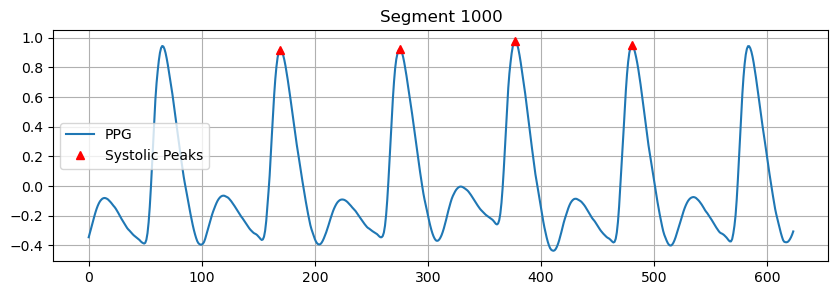

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(xf, label='PPG')
plt.plot(loc1, xf[loc1], 'r^', label='Systolic Peaks')
#plt.plot(loc2_foot, np.array(pk1_foot), 'go', label='Foot Points')
plt.legend()
plt.title(f"Segment {j+1}")
plt.grid()
plt.show()

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.datasets import make_classification
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



dataset_test0=df_SBP_PPG_Feat[:]
dataset_test00=dataset_test0.assign(output=0)
dataset_test=dataset_test00.dropna()


XX_test = dataset_test.iloc[0:,0:12]
YY_test = dataset_test[['output']]
model4=joblib.load('model4_best_Feat_raw.joblib')
YY_pred_4 = model4.predict(XX_test)
conf_matrix = confusion_matrix(YY_test, YY_pred_4)


In [155]:
YY_pred_4

array([0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2,
       2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2,
       2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0,